# Подготовительные действия

## Настройка среды


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
DRIVE_PATH = '/content/drive/My Drive/IRPNet files/'

In [3]:
from utils import *
t = Timer()

Информация о видеокарте, на которой будут производиться вычисления

In [4]:
!nvidia-smi

Thu May 12 12:16:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import torch

In [6]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

## Загрузка данных

In [7]:
import pickle

In [8]:
with open(f'{DRIVE_PATH}token_dict.pkl', 'rb') as file:
    token_ids = pickle.load(file)

In [9]:
emb_tensor = torch.load(f'{DRIVE_PATH}embedding.pt')

In [10]:
with open(f'{DRIVE_PATH}filtred_reviews.pkl', 'rb') as file:
    reviews = pickle.load(file)

In [11]:
review_tensors = [torch.tensor(ids, dtype=torch.long, device=DEVICE)
                  for ids, _ in reviews]

In [12]:
EMBEDDING_SIZE = 32

## Функции для работы с батчами

Поскольку нейросеть осуществляет классификацию с помощью двух выходов, необходимо преобразовать маркировку в правильный формат

In [13]:
def mark_to_classes(mark):
    return [1, 0] if mark else [0, 1]

|      Тензор     |          Размерность           |
|:--------------:|:-----------------------------|
| reviews_tensor | (batch_size, review_max_len) |
|  marks_tensor  | (batch_size, 2)              |

In [14]:
def reviews_to_tensor(reviews_list):
    max_len = len(max(reviews_list, 
                      key=lambda review: len(review[0]))[0])
    batch_size = len(reviews_list)

    reviews_tensor = torch.zeros(batch_size, max_len, 
                                 dtype=torch.long, 
                                 device=DEVICE)
    marks_tensor = torch.zeros(batch_size, 2,
                               dtype=torch.float, 
                               device=DEVICE)
    
    for i, review in enumerate(reviews_list):
        ids, mark = review
        start_idx = max_len - len(ids)

        reviews_tensor[i, start_idx:] = torch.tensor(ids, 
                                                     dtype=torch.long, 
                                                     device=DEVICE)
        marks_tensor[i] = torch.tensor(mark_to_classes(mark), 
                                       dtype=torch.float,
                                       device=DEVICE)
        
    return reviews_tensor, marks_tensor

In [15]:
import re

In [16]:
TOKEN_RE = re.compile(r'(?:[\w\d]+\-[\w\d]+)|[\w\d]+')

Для обработки текстовой рецензии необходимо перевести ее в последовательность идентификаторов токенов, чтобы нейросеть могла выполнить эмбеддинг

In [17]:
def review_to_tokens(review):
  return [token_ids[token] 
          for token in TOKEN_RE.findall(review.lower())
          if token in token_ids]

## Расчет метрик качества

|              |       $y = 1$       |        $y = 0$       |
|:------------:|:-------------------:|:--------------------:|
| $\hat y = 1$ | TP (true positive)  | FP (false poositive) |
| $\hat y = 0$ | FN (false negative) | TN (true negative)   |


В некоторых случаях может получиться деление на ноль, поэтому в каждой дроби к знаменателю прибавляется маленькое число $epsilon = 10^{-10}$

In [18]:
class ConfusionValues:
    def __init__(self, TP=0, FP=0, FN=0, TN=0):
        self.TP = TP
        self.FP = FP
        self.FN = FN
        self.TN = TN
        self.epsilon = 1.0e-10
        
    def add(self, TP=0, FP=0, FN=0, TN=0):
        self.TP += TP
        self.FP += FP
        self.FN += FN
        self.TN += TN

    def plus(self, another):
        self.add(*another.values())

    def values(self):
        return (self.TP, self.FP, self.FN, self.TN)

    def print_values(self):
        print(f'TP = {self.TP}')
        print(f'FP = {self.FP}')
        print(f'FN = {self.FN}')
        print(f'TN = {self.TN}')
        
    def accuracy(self):
        total = self.TP + self.TN + self.FP + self.FN + self.epsilon
        return (self.TP + self.TN) / total

    def precision(self):
        return self.TP / (self.TP + self.FP + self.epsilon)

    def recall(self):
        return self.TP / (self.TP + self.FN + self.epsilon)

    def f1_score(self):
        recall = self.recall()
        precision = self.precision()
        return 2 * precision * recall / (precision + recall + self.epsilon)

Поскольку вычислительной мощности не хватает на одновременную обработку сразу всей выборки, приходится делить ее на мини-батчи и вычислять последовательно

In [19]:
def get_confusion_values_batch(y_hat_batch, y_batch):
    conf_values = ConfusionValues()

    for y_hat, y in zip(y_hat_batch, y_batch):
        y_hat_norm = y_hat.argmin().item()
        y_value = y.argmin().item()
        conf_values.add(TP=(y_hat_norm and y_value),
                        FP=(y_hat_norm and not y_value),
                        FN=(not y_hat_norm and y_value),
                        TN=(not y_hat_norm and not y_value))
        
    return conf_values

In [20]:
def get_confusion_values(dataset, batch_size=1000):
    conf_values = ConfusionValues()

    for start_index in range(0, len(dataset), batch_size):
        x_batch, y_batch = reviews_to_tensor(dataset[start_index : start_index+batch_size])
        with torch.no_grad():
            y_hat_batch = net.forward(x_batch)
            torch.cuda.empty_cache()

        conf_values.plus(get_confusion_values_batch(y_hat_batch,
                                                    y_batch))

    return conf_values

In [21]:
def print_metrics(dataset):
    conf_values = get_confusion_values(dataset)
    print(f'{"Accuracy":>10} = {conf_values.accuracy()}')
    print(f'{"Precision":>10} = {conf_values.precision()}')
    print(f'{"Recall":>10} = {conf_values.recall()}')
    print(f'{"F1-score":>10} = {conf_values.f1_score()}')

# Нейронная сеть

## Архитектура модели

In [22]:
import torch.nn as nn

In [23]:
HIDDEN_SIZE = 64
OUTPUT_SIZE = 2
RNN_LAYERS = 1
FC_HIDDEN_SIZE = 128

|\#|Этап         |Входной тензор                              |Выходной тензор
|-:|:------------|:-------------------------------------------|:------------
| 1|input        |-                                           |(batch_size, review_max_len)
| 2|embedding    |(batch_size, review_max_len)                |(batch_size, review_max_len, embedding_size)
| 3|LSTM         |- **input**: (batch_size, review_max_len, embedding_size)<br> - **h_0**: (rnn_layers, batch_size, hidden_size)<br> - **c_0**: (rnn_layers, batch_size, hidden_size)|- **output**: (batch_size, review_max_len, hidden_size)<br>- **h_n**: (rnn_layers, batch_size, hidden_size)<br>- **c_n**: (rnn_layers, batch_size, hidden_size)
| 4|take last h_n|(rnn_layers, batch_size, hidden_size)                |(batch_size, hidden_size) 
| 5|FC-layer 1   |(batch_size, hidden_size)                   |(batch_size, fc_hidden_size)
| 6|FC-layer 2   |(batch_size, fc_hidden_size)                |(batch_size, output_size)
| 7|output       |(batch_size, output_size)                   |-

In [24]:
class IRPNet_LSTM(nn.Module):
    def __init__(self, 
                 embedding_size=EMBEDDING_SIZE, 
                 hidden_size=HIDDEN_SIZE,
                 output_size=OUTPUT_SIZE,
                 fc_hidden_size=FC_HIDDEN_SIZE,
                 rnn_layers=RNN_LAYERS):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.rnn_layers = rnn_layers
        
        self.emb = nn.Embedding.from_pretrained(emb_tensor)

        self.rnn = nn.LSTM(input_size=embedding_size, 
                           hidden_size=hidden_size,
                           num_layers=rnn_layers,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size)
        self.act1 = nn.Sigmoid()
        self.drop = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(fc_hidden_size, output_size)
        self.act2 = nn.Softmax(dim=1)
        
    def forward(self, input_batch):
        batch_size = input_batch.size()[0]

        input_emb = self.emb(input_batch)
        output, (h, c) = self.rnn(input_emb, (self.init_hidden(batch_size),
                                              self.init_hidden(batch_size)))
        x = h[-1]
        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.act2(x)
        
        return x
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.rnn_layers, batch_size, self.hidden_size, 
                           dtype=torch.float, device=DEVICE)

## Формирование выборки

In [25]:
import random
import pandas as pd

На тренировочную выборку (для обучения сети) берется 70% всех рецензий, а оставшиеся 30% отводятся под валидационную (тестовую) выборку, на основе которой будет проверяться эффективность работы сети

In [26]:
total_data_size = len(reviews)
separator_index = int(total_data_size * 0.7)

train_data = reviews[:separator_index]
test_data = reviews[separator_index:]

data = {'Выборка': ['Вся', 'Тренировочная', 'Тестовая'], 
        'Размер': [total_data_size, len(train_data), len(test_data)]}

pd.DataFrame(data).style.hide_index()

Выборка,Размер
Вся,50000
Тренировочная,35000
Тестовая,15000


## Обучение модели

In [27]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [28]:
net = IRPNet_LSTM().to(DEVICE)

- В качестве функции потерь используется кросс-энтропия
- В качестве оптимизатора используется Adam со стандартными параметрами и начальной скоростью обучения $10^{-3}$
- Если на протяжении 20 эпох обучения метрика качества не улучается, скорость обучения уменьшается в два раза (scheduler)

In [29]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       patience=20,
                                                       factor=0.5)

In [30]:
history_test = []
history_train = []

Обучение производится в 100 эпох

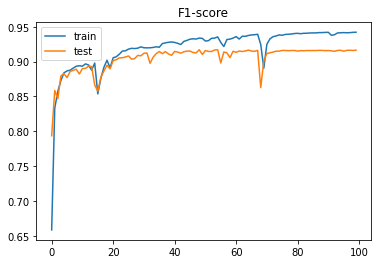

Завершено за 00:17:17.494


In [31]:
t.start()

torch.cuda.empty_cache()

EPOCH_COUNT = 100
BATCH_SIZE = 1000
ITERS_PER_EPOCH = len(train_data) // BATCH_SIZE
TOTAL_ITERS = EPOCH_COUNT * ITERS_PER_EPOCH

for epoch in range(EPOCH_COUNT):
    confusion_values_train = ConfusionValues()
    net.train()

    random.shuffle(train_data)
    for start_index in range(0, len(train_data), BATCH_SIZE):
        x_batch, y_batch = reviews_to_tensor(
            train_data[start_index : start_index+BATCH_SIZE])
        
        optimizer.zero_grad()
        
        preds = net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

        confusion_values_train.plus(get_confusion_values_batch(preds,
                                                               y_batch))
        
        current_iters = epoch * ITERS_PER_EPOCH + (start_index // BATCH_SIZE)
        label = f'{(epoch+1):>3}/{EPOCH_COUNT} '
        label += f'({round(start_index / (len(train_data) - 1) * 100):>3}%) '
        label += progress_bar(current_iters, TOTAL_ITERS)
        label += f' {t.elapsed():<12} | '
        label += f'lr={optimizer.param_groups[0]["lr"]}'
        print('\r' + label, end='')
    
    net.eval()

    f1_score_train = confusion_values_train.f1_score()
    history_train.append(f1_score_train)

    confusion_values = get_confusion_values(test_data)
    f1_score_test = confusion_values.f1_score()
    history_test.append(f1_score_test)

    scheduler.step(f1_score_test)
        
    clear_output(True)
    plt.title('F1-score')
    plt.plot(history_train, label=f'train')
    plt.plot(history_test, label=f'test')
    plt.legend()
    plt.show()

t.stop()

# Тестирование

## Проверка работы на некоторых примерах

Простейшая функция для вывода результатов работы сети

In [32]:
def process_review(review):
    reviews_tensor, _ = reviews_to_tensor([(review_to_tokens(review), 0)])
    
    with torch.no_grad():
        output = net(reviews_tensor)
        torch.cuda.empty_cache()
    
    for label, value in zip(['Positive:', 'Negative:'], output.view(-1)):
        print(label, round(value.item(), 6))

In [33]:
process_review('Купил телефон, а он ни о чем! Памяти мало, батарея хоть и хорошая, но зарядки нет в комплекте, остался недоволен')

Positive: 0.015516
Negative: 0.984484


In [34]:
process_review('Купил телефон, ни о чем не жалею! Мощный, красивый, с большим экраном, рекомендую!')

Positive: 0.999434
Negative: 0.000566


Расчет метрик качества для тренировочной и валидационной выборки

In [35]:
t.start()

print('train:')
print_metrics(train_data)
print('\ntest:')
print_metrics(test_data)
print()

t.stop()

train:
  Accuracy = 0.9430857142857115
 Precision = 0.9492858382004226
    Recall = 0.9363983800125439
  F1-score = 0.9427980702463443

test:
  Accuracy = 0.9174666666666605
 Precision = 0.9237046103631045
    Recall = 0.9093586825545467
  F1-score = 0.9164755093279423

Завершено за 00:00:7.29


## Проверка работы на всей выборке из более чем 250'000 рецензий

In [36]:
with open(f'{DRIVE_PATH}all_reviews.pkl', 'rb') as file:
    all_reviews = pickle.load(file)

In [37]:
t.start()

print_metrics(all_reviews)
print()

t.stop()

  Accuracy = 0.9134621659162305
 Precision = 0.9914457491022066
    Recall = 0.909656810116406
  F1-score = 0.9487919240454142

Завершено за 00:00:33.817


# Сохранение модели

Сохранение всех весов модели

In [38]:
torch.save(net.state_dict(), f'{DRIVE_PATH}IRPNet.pt')

Сохранение истории обучения

In [39]:
with open(f'{DRIVE_PATH}history_train.pkl', 'bw') as f_train:
    pickle.dump(history_train, f_train)

with open(f'{DRIVE_PATH}history_test.pkl', 'bw') as f_test:
    pickle.dump(history_test, f_test)